In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from keras.models import Graph
from keras.layers.recurrent import LSTM
from keras.layers.core import AutoEncoder, Dense, Activation, TimeDistributedDense, Flatten, Dropout, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from helper import generate_train_test_set
from lstm_networks import *

# Setup

In [2]:
# Parameters
vocabulary_size = 196
embedding_size = 10
encoding_size = 30
decoding_size = 10
sequence_length = 90
n_epochs = 5

In [3]:
# Load datasets
df_train, df_test = generate_train_test_set('data/dataset_60k_20.csv', is_supervised=False)
addresses = df_train['address'].values

# Generate feature matrices
input_matrix, input_size = generate_input_matrix(addresses, max_length=sequence_length)
target_vectors = generate_target_vectors(input_matrix, input_size)
true_y = np.array([1 if x == 'VALID' else 0 for x in df_train.label.values])

# Generate test/validation matrices
index1, index2 = StratifiedKFold(df_test['label'], n_folds=2, random_state=43)
valid_index, test_index = index1
df_valid = df_test.iloc[valid_index]
df_final_test = df_test.iloc[test_index]
valid_matrix, valid_size = generate_input_matrix(df_valid['address'], feature_count=input_size, max_length=sequence_length)
valid_target_vectors = generate_target_vectors(valid_matrix, input_size)
test_matrix, test_size = generate_input_matrix(df_final_test['address'], feature_count=input_size, max_length=sequence_length)
test_target_vectors = generate_target_vectors(test_matrix, input_size)

test_labels = [1.0 if x == 'VALID' else 0.0 for x in df_final_test.label.values]
valid_labels = [1.0 if x == 'VALID' else 0.0 for x in df_valid.label.values]

# Build model

In [4]:
model = Graph()
model.add_input(name='input', dtype='int32') #embedding needs int32
# Encoding input into a representation
model.add_node(Embedding(input_dim=vocabulary_size, output_dim=embedding_size),
               name='embedding',
               input='input')
model.add_node(LSTM(input_dim=embedding_size, output_dim=encoding_size, return_sequences=True),
               name='encoder',
               input='embedding')
# Branch 1: reconstruct
model.add_node(LSTM(input_dim=encoding_size, output_dim=decoding_size, return_sequences=True),
               name='decoder',
               input='encoder')
model.add_node(TimeDistributedDense(input_dim=decoding_size, output_dim=vocabulary_size, activation='softmax'),
               name='distributed',
               input='decoder')
model.add_output(name='reconstruction', input='distributed')
# Branch 2: classify
model.add_node(TimeDistributedDense(input_dim=encoding_size, output_dim=1),
               name='transition',
               input='encoder')
model.add_node(Flatten(), name='transition2', input='transition')
model.add_node(Dropout(0.5), name='dropout', input='transition2')
model.add_node(Dense(input_dim=sequence_length, output_dim=1, activation='sigmoid'),
               name='dense',
               input='dropout')
model.add_output(name='classification', input='dense')

In [5]:
model.compile(optimizer='rmsprop', loss={'reconstruction':'mse', 'classification':'binary_crossentropy'}) # XXX mse?

/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


# Experimenting with different levels of supervision

In [8]:
scores = []
init_weights = model.get_weights()
best_weights = None
fractions = np.arange(0, 1.1, 0.1)

# Model architecture + weights for each level of supervision saved in models/semisup
with open('models/semisup/architecture.json', 'w+') as f:
        f.write(model.to_json())

for frac in fractions:
    # Mask classification output, to simulate unlabeled data
    mask = np.zeros(true_y.shape)
    mask[np.where(np.random.random(true_y.shape) < frac)] = 1
    output_mask = {'classification': mask}
    print frac
    
    # Fit model from scratch
    model.set_weights(init_weights)
    model.fit({'input': input_matrix, 'reconstruction': target_vectors, 'classification': true_y},
              batch_size=32, nb_epoch=n_epochs, sample_weight=output_mask)
    predictions = model.predict({'input': test_matrix})
    class_predictions = [0 if p < 0.5 else 1 for p in predictions['classification']]
    
    # Metrics
    f1 = f1_score(test_labels, class_predictions)
    print f1
    precision, recall, fscore, support = precision_recall_fscore_support(test_labels, class_predictions)
    print precision # invalid, valid
    print recall
    print '-' * 80
    
    if len(scores) == 0 or f1 > np.max(scores):
        best_weights = model.get_weights()
    scores.append(f1)
    
    model.save_weights('models/semisup/{0}_weights.h5'.format(frac))
    
print scores

0.0
Epoch 0
39600/39600 [==============================] - 128s - loss: nan   
Epoch 1
39600/39600 [==============================] - 128s - loss: nan   
Epoch 2
39600/39600 [==============================] - 129s - loss: nan   
Epoch 3
39600/39600 [==============================] - 129s - loss: nan   
Epoch 4
39600/39600 [==============================] - 129s - loss: nan   
0.64
[ 0.          0.47058824]
[ 0.  1.]
--------------------------------------------------------------------------------
0.1
Epoch 0
39600/39600 [==============================] - 131s - loss: nan   
Epoch 1
39600/39600 [==============================] - 130s - loss: nan   
Epoch 2
39600/39600 [==============================] - 130s - loss: nan   
Epoch 3
39600/39600 [==============================] - 130s - loss: nan   
Epoch 4
39600/39600 [==============================] - 130s - loss: nan   
0.83706865884
[ 0.97497338  0.73029174]
[ 0.67814815  0.98041667]
------------------------------------------------------

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


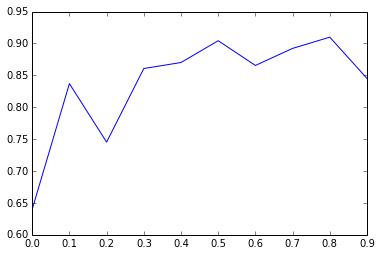

In [5]:
plt.plot(fractions, scores)

# Compare embeddings

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


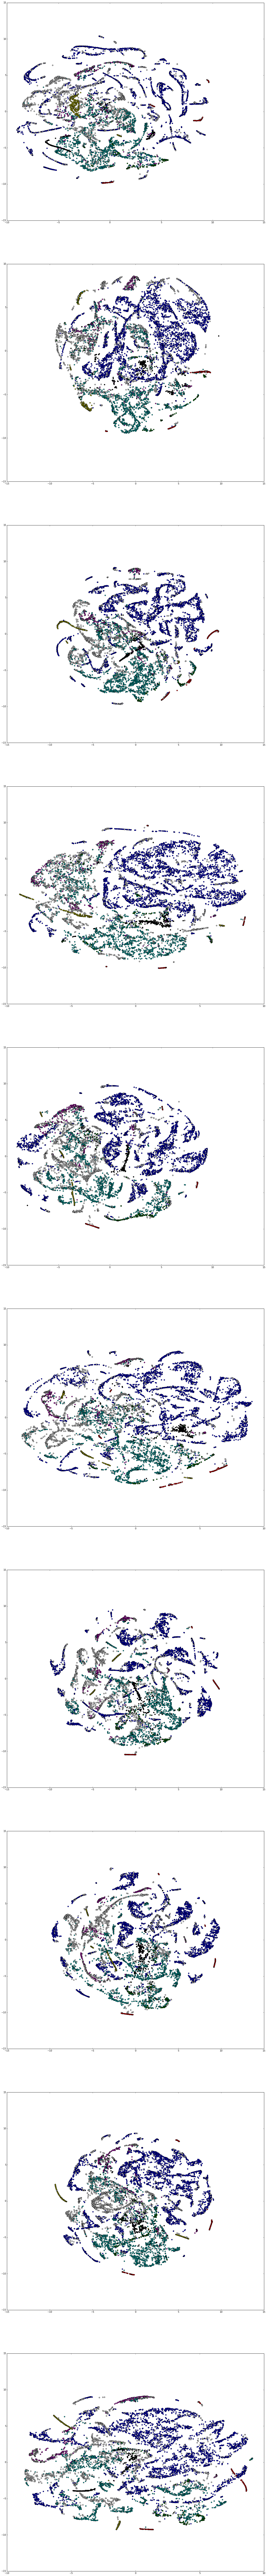

In [27]:
tsne = TSNE(random_state=43)
c = {
    'COUNTRY': 'g',
    'DATE': 'r',
    'DUTCH_ADDRESS': 'c',
    'EMAIL': 'm',
    'PHONE_NUMBER': 'y',
    'RANDOM_TEXT': 'k', 
    'SHUFFLED_ADDRESS': 'w',
    'URL': '0.75'
}

colors = ['b' if l else c[s] for l, s in zip(valid_labels, df_valid['source'].values)]
plt.figure(figsize=(20,200))
outputs = []

for frac in fractions:
    print frac
    # load trained model
    model = load_trained_model('models/semisup/architecture.json', 'models/semisup/{0}_weights.h5'.format(frac))
    
    # get just the encoder
    encoder = Sequential()
    encoder.add(model.nodes['embedding'])
    encoder.add(model.nodes['encoder'])
    encoder.add(model.nodes['transition'])
    encoder.add(model.nodes['transition2']) # XXX is this the right encoder? this branch leads to classifier....
    encoder.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    # embed points
    vectors = encoder.predict(valid_matrix)
    
    # display embedding with t-SNE
    output = tsne.fit_transform(vectors)
    outputs.append(output)
    plt.subplot(10, 1, frac / 0.1)
    plt.scatter(output[:, 0], output[:, 1], c=colors)